# Module 7 : Wrap up Quizzzzzzz

Open the dataset bike_rides.csv with the following commands:

```
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()
```

A detailed description of this dataset is given in the appendix. As a reminder, the problem we are trying to solve with this dataset is to use measurements from cheap sensors (GPS, heart-rate monitor, etc.) in order to predict a cyclist power. Power can indeed be recorded via a cycling power meter device, but this device is rather expensive.

Instead of using blindly machine learning, we will first introduce some flavor of classic mechanics: the Newton's second law.

`Pmeca=(12ρ.SCx.Va2+Cr.mg.cosα+mg.sinα+ma)Vd`

where ρ is the air density in kg.m−3, S is frontal surface of the cyclist in m2, Cx is the drag coefficient, Va is the air speed in m.s−1, Cr is the rolling coefficient, m is the mass of the rider and bicycle in kg, g is the standard acceleration due to gravity which is equal to 9.81 m.s−2, α is the slope in radian, Vd is the rider speed in m.s−1, and a is the rider acceleration in m.s−2.

This equation might look a bit complex at first but we can explain with words what the different terms within the parenthesis are:

the first term is the power that a cyclist is required to produce to fight wind
the second term is the power that a cyclist is required to produce to fight the rolling resistance created by the tires on the floor
the third term is the power that a cyclist is required to produce to go up a hill if the slope is positive. If the slope is negative the cyclist does not need to produce any power to go forward
the fourth and last term is the power that a cyclist requires to change his speed (i.e. acceleration).
We can simplify the model above by using the data that we have at hand. It would look like the following.

`Pmeca=β1V3d+β2Vd+β3sin(α)Vd+β4aVd`

This model is closer to what we saw previously: it is a linear model trained on a non-linear feature transformation. We will build, train and evaluate such a model as part of this exercise. Thus, you need to:

create a new data matrix containing the cube of the speed, the speed, the speed multiplied by the sine of the angle of the slope, and the speed multiplied by the acceleration. To compute the angle of the slope, you need to take the arc tangent of the slope (alpha = np.arctan(slope)). In addition, we can limit ourself to positive acceleration only by clipping to 0 the negative acceleration values (they would correspond to some power created by the braking that we are not modeling here).
using the new data matrix, create a linear predictive model based on a sklearn.preprocessing.StandardScaler and a sklearn.linear_model.RidgeCV;
use a sklearn.model_selection.ShuffleSplit cross-validation strategy with only 4 splits (n_splits=4) to evaluate the statistical performance of the model. Use the mean absolute error (MAE) as a statistical performance metric. Also, pass the parameter return_estimator=True and return_train_score=True to answer the subsequent questions. Be aware that the ShuffleSplit strategy is a naive strategy and we will investigate the consequence of making this choice in the subsequent questions.

In [15]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


#### Question 1 (1 point possible)
What is the mean value of the column containing the information of sin(α)Vd?

 a) about -3  
 b) about -0.3  
 c) about -0.03  
 d) about -0.003

 C'est la d)

In [16]:
import numpy as np

matrix = pd.DataFrame(list(zip(
    data["speed"]**3, 
    data["speed"], 
    data["speed"]*np.sin(np.arctan(data["slope"])),
    data["speed"]*data["acceleration"].clip(lower=0) 
    )), columns=['Wind', 'Rolling resistance', 'Up a hill', 'Acceleration'])

matrix["Up a hill"].mean()

-0.002709709612566326

#### Question 2 (1 point possible)
On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:

 a) 20 Watts  
 b) 50 Watts  
 c) 70 Watts  
 d) 90 Watts  
 
 ~73 Watts

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

model = make_pipeline(
      StandardScaler(),
      RidgeCV()
)

cv = ShuffleSplit(n_splits=4)
cv_results = cross_validate(model, matrix, target, cv=cv, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')

print(f"Test score : {-cv_results['test_score'].mean():.2f}\n"
    f"Train score : {-cv_results['train_score'].mean():.2f}"
)

Test score : 72.23
Train score : 72.50


#### Question 3 (1 point possible)
Given the model Pmeca=β1V3d+β2Vd+β3sin(α)Vd+β4aVd that you created, inspect the weights of the linear models fitted during cross-validation and select the correct statements:

 a) β1<β2<β3  
 b) β3<β1<β2  
 c) β2<β3<β1  
 d) β1<0  
 e) β2<0  
 f) β3<0  
 g) β4<0  
 h) All βs are > 0

 Je dirais a) et h)

In [18]:
[est[-1].coef_ for est in cv_results["estimator"]]

[array([ 5.63992012, 32.78762794, 80.31461499, 11.19216161]),
 array([ 5.9790671 , 32.54616457, 80.94832873, 11.33560404]),
 array([ 5.81659074, 32.55379135, 80.489963  , 11.08052272]),
 array([ 4.81756676, 33.02020839, 79.96810534, 11.15020922])]

#### Question 4 (1 point possible)
Now, we will create a predictive model that uses all available sensor measurements such as cadence (the speed at which a cyclist turns pedals measured in rotation per minute) and heart-rate (the number of beat per minute of the heart of the cyclist while exercising). Also, we will use a non-linear regressor, a sklearn.ensemble.HistGradientBoostingRegressor.

Fix the number of maximum iterations to 1000 (max_iter=1_000) and activate the early stopping (early_stopping=True). Repeat the previous evaluation using this regressor.

On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:

 a) 20 Watts  
 b) 40 Watts  
 c) 60 Watts  
 d) 80 Watts

 J'ai dit c) car j'avais continué à utiliser matrix alors qu'il fallait prendre data...

In [19]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(max_iter=1000, early_stopping=True)
cv_results = cross_validate(hgb, data, target, cv=cv, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')

print(f"Test score : {-cv_results['test_score'].mean():.2f}\n"
    f"Train score : {-cv_results['train_score'].mean():.2f}"
)


Test score : 43.58
Train score : 39.76


#### Question 5 (1 point possible)
Comparing both the linear model and the histogram gradient boosting model and taking into consideration the train and test MAE obtained via cross-validation, select the correct statements:

 a) the statistical performance of the histogram gradient-boosting model is limited by its underfitting  
 b) the statistical performance of the histogram gradient-boosting model is limited by its overfitting  
 c) the statistical performance of the linear model is limited by its underfitting  
 d) the statistical performance of the linear model is limited by its overfitting

 Je me suis trompé... Il y a overfitting pour le HistGradientBoosting car le test score > train score.
 Il y a underfitting du modele linéaire car la MAE est de 70 alors que HistGradientBoosting est de 40

#### Question 6 (1 point possible)
In the previous cross-validation, we made the choice of using a ShuffleSplit cross-validation strategy. It means that randomly selected samples were selected as a testing test ignoring any time dependency between the lines of the dataframe.

We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike ride: the samples in the validation set should only come from rides not present in the training set.

How many bike rides are stored in the dataframe data? Do not hesitate to look at the hints.

 a) 2  
 b) 3  
 c) 4  
 d) 5
Je dirais c)

In [29]:
set(data.index.date)

{datetime.date(2020, 8, 18),
 datetime.date(2020, 8, 20),
 datetime.date(2020, 8, 26),
 datetime.date(2020, 9, 13)}

#### Question 7 (1 point possible)
Instead of using the naive ShuffleSplit strategy, we will use a strategy that takes into account the group defined by each individual date. It corresponds to a bike ride. We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike ride: the samples in the validation set should only come from rides not present in the training set. Therefore, we can use a LeaveOneGroupOut strategy: at each iteration of the cross-validation, we will keep a bike ride for the evaluation and use all other bike rides to train our model.

Thus, you concretely need to:

create a variable called group that is a 1D numpy array containing the index of each ride present in the dataframe. Therefore, the length of group will be equal to the number of samples in data. If we had 2 bike rides, we would expect the indices 0 and 1 in group to differentiate the bike ride. You can use pd.factorize to encode any Python types into integer indices.
create a cross-validation object named cv using the sklearn.model_selection.LeaveOneGroupOut strategy.
evaluate both the linear and histogram gradient boosting models with this strategy.
Using the previous evaluations (with both ShuffleSplit and LeaveOneGroupOut) and looking at the train and test errors for both models, select the correct statements:

 a) the statistical performance of the gradient-boosting model is limited by its underfitting  
 b) the statistical performance of the gradient-boosting model is limited by its overfitting  
 c) the statistical performance of the linear model is limited by its underfitting  
 d) the statistical performance of the linear model is limited by its overfitting

 J'ai eu faux car j'ai oublié de faire group[0] au lieu de group..

In [62]:
from sklearn.model_selection import LeaveOneGroupOut

group = pd.factorize(data.index.to_period("D"))
group = group[0]
cv = LeaveOneGroupOut()

linear_model = make_pipeline(StandardScaler(), RidgeCV())
hgb_model = HistGradientBoostingRegressor(max_iter=1000, early_stopping=True)

linear_cv_results = cross_validate(linear_model, data, target, cv=cv, scoring='neg_mean_absolute_error', groups=group, n_jobs=2, return_estimator=True, return_train_score=True)
hgb_cv_results = cross_validate(hgb_model, data, target, cv=cv, scoring='neg_mean_absolute_error', groups=group, n_jobs=2, return_estimator=True, return_train_score=True)

print(f"LINEAR Test score : {-linear_cv_results['test_score'].mean():.2f}\n"
    f"LINEAR  Train score : {-linear_cv_results['train_score'].mean():.2f}")

print(f"HGB Test score : {-hgb_cv_results['test_score'].mean():.2f}\n"
    f"HGB Train score : {-hgb_cv_results['train_score'].mean():.2f}")

LINEAR Test score : 64.76
LINEAR  Train score : 64.59
HGB Test score : 50.17
HGB Train score : 37.40


#### Question 8 (1 point possible)
Using the previous evaluations (with both ShuffleSplit and LeaveOneGroupOut) and looking at the train and test errors for both models, select the correct statements:

 a) ShuffleSplit is giving over-optimistic results for the linear model  
 b) LeaveOneGroupOut is giving over-optimistic results for the linear model  
 c) both cross-validation strategies are equivalent for the linear model  
 d) ShuffleSplit is giving over-optimistic results for the gradient-boosting model  
 e) LeaveOneGroupOut is giving over-optimistic results for the gradient-boosting model  
 f) both cross-validation strategies are equivalent for the gradient-boosting model

 Encore faux
 

#### Question 9 (1/1 point)
Compare more precisely the errors estimated through cross-validation and select the correct statement:

 a) in general, the standard deviation of the train and test errors increased using the LeaveOneGroupOut cross-validation
 b) in general, the standard deviation of the train and test errors decreased using the LeaveOneGroupOut cross-validation

 Enfin bon  c'est a)

#### Question 10 (1 point possible)
Now, we will go in details by picking a single ride for the testing and analyse the predictions of the models for this test ride. To do so, we can reuse the LeaveOneGroupOut cross-validation object in the following manner:
```
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]
```
Now, fit both the linear model and the histogram gradient boosting regressor models on the training data and collect the predictions on the testing data. Make a scatter plot where on the x-axis, you will plot the measured powers (true target) and on the y-axis, you will plot the predicted powers (predicted target). Do two separated plots for each model.

By analysing the plots, select the correct statements:

 a) the linear regressor tends to under-predict samples with high power  
 b) the linear regressor tends to over-predict samples with high power  
 c) the linear regressor makes catastrophic predictions for samples with low power  
 d) the histogram gradient boosting regressor tends to under-predict samples with high power  
 e) the histogram gradient boosting regressor tends to over-predict samples with high power  
 f) the histogram gradient boosting makes catastrophic predictions for samples with low power

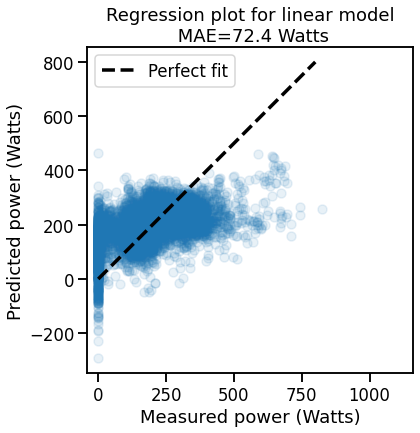

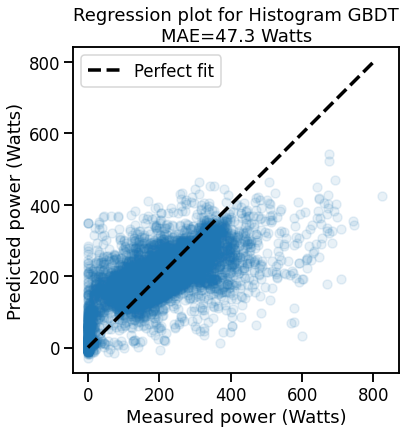

In [80]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# extract the dataset
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=group))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

# fit models and collect predictions
linear_model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = linear_model.predict(data_linear_model_test)

hgbdt.fit(data_train, target_train)
target_predicted_hgbdt = hgbdt.predict(data_test)

# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

#### Question 11 (1 point possible)
Now select a portion of the testing data using the following code:
```
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]
```
It allows to select data from 5.00 pm until 5.05 pm. Used the previous fitted models (linear and gradient-boosting regressor) to predict on this portion of the test data. Draw on the same plot the true targets and the predictions of each model.

By using the previous plot, select the correct statements:

 a) the linear model is more accurate than the histogram gradient boosting regressor  
 b) the histogram gradient boosting regressor is more accurate than the linear model  
 c) the linear model predicts smoother outputs than the histogram gradient boosting regressor  
 d) the histogram gradient boosting regressor predicts smoother outputs than the linear model

In [82]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

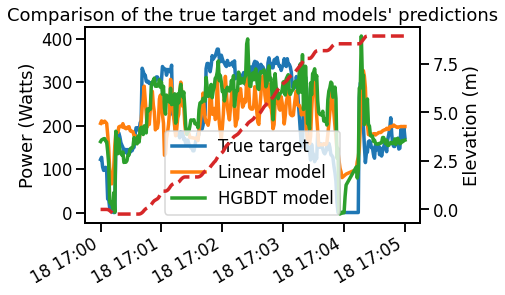

In [89]:

time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target")
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")